In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# path to your specola database archive csv file, for more info on specola datasets, please visit:
# https://sunspots.irsol.usi.ch/db/choose-dl-year.php
specola_data_csv_file_path = './sunspot_data_excel.csv'

df = pd.read_csv(specola_data_csv_file_path)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# print the head to verify pandas is reading the file correctly
df.head()

,date,time,group nr.,weighted spot count,type,latitude,longitude
0,6/1/1957,7:55,275,2,J,-10.1,179.9
1,6/1/1957,7:55,278,19,H,21.4,157.9
2,6/1/1957,7:55,281,28,C,-22.5,129.8
3,6/1/1957,7:55,286,6,B,19.3,171.3
4,6/1/1957,7:55,288,15,C,-22.5,92.2


In [10]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month    
df['day'] = df['date'].dt.day
# Filter out rows where 'group nr.' is NaN or contains letters
# Group number of NAN indicates data wasnt available on that day/time
# Group number with letters indicates the observers were unsure if the sunspot was part of a particular group
df = df[df['group nr.'].notna() & df['group nr.'].apply(lambda x: re.match(r'^\d+$', str(x)) is not None)]

In [12]:
# WE WILL CLASSIFY UNDEVELOPED AND DEVELOPED AS:
# undeveloped = {"A", "B", "C"} #no prenumbra
# developed = {"D", "E", "F"} # developed prenumbra
# decayed = {"G", "H","J"}
# other = {"X"}

In [14]:
solar_maximum_years = [1958,1968,1980, 1990, 2001, 2014]
solar_minimum_years = [1964,1976, 1986, 1996, 2008, 2019]

In [16]:
list_of_years = ['1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', 
                 '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', 
                 '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', 
                 '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', 
                 '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', 
                 '2018','2019','2020','2021','2022']

In [18]:
# Unique list of years in the dataset
years = sorted(df['year'].unique())

# Initialize
group_categories_global = []

list_of_percentages = {}
for year in years:
    # Filter the DataFrame for the current year
    df_year = df[df['year'] == year]

    # Initialize a dictionary to track the categories the sunspot groups appear for the current year
    group_categories = {}

    # Process each row -> looping through the current year and doing operations one row at a time
    for index, row in df_year.iterrows():
        group_number = row['group nr.']
        type1 = row['type']
        if group_number not in group_categories:
            group_categories[group_number] = [type1]
        else:
            group_categories[group_number].append(type1)
        
    # Checks for potential overlaps by comparing the last two months of the current year
    # with the first two months of the next year. This can be extended to however many months you wish to filter
    if year + 1 in years:
        df_current_last_two_months = df[(df['year'] == year) & (df['month'] >= 11)]
        df_next_first_two_months = df[(df['year'] == year + 1) & (df['month'] <= 2)]

        for index, row in df_current_last_two_months.iterrows():

            group_number = row['group nr.']
            # Check if this group also appears in the next year's first two months
            df_next_group = df_next_first_two_months[df_next_first_two_months['group nr.'] == group_number]
            #that group appeared in the next year
            if not df_next_group.empty:
                #UNCOMMENT FOR DEBUG PURPOSES
                #print(f"this group appears in the next year {df_next_group['group nr.']}")
                
                latest_next_year_type = df_next_group['type'].iloc[-1]
                #UNCOMMENT FOR DEBUG PURPOSES
                #print("latest appearance of the group in the next year is: {}".format(latest_next_year_type))
                if latest_next_year_type not in group_categories[group_number]:
                    group_categories[group_number].append(latest_next_year_type)
                    #UNCOMMENT FOR DEBUG PURPOSES
                    #print(group_categories[str(group_number)])
    
    undeveloped = {"A", "B", "C"} #no prenumbra
    developed = {"D", "E", "F"} # developed prenumbra
    decayed = {"G", "H","J"}
    other = {"X"}

    total = 0
    total_swing = 0
    total_undeveloped = 0
    total_developed = 0
    total_decayed = 0
    #now for each group
    for g_num, types in group_categories.items():
        # Convert the list to a set for easier comparison
        sunspot_type_set = set(types)
        
        # Check for exclusive membership in undeveloped or developed types
        if sunspot_type_set.issubset(undeveloped):
            # print(f"This group was in undeveloped: ({g_num},{types})")
            group_categories[g_num] = "undeveloped"
            total_undeveloped += 1
        elif sunspot_type_set.issubset(developed):
            # print(f"This group was in developed: ({g_num},{types})")
            group_categories[g_num] = "developed"
            total_developed += 1
        elif sunspot_type_set.issubset(decayed):
            # print(f"This group was in decayed: ({g_num},{types})")
            group_categories[g_num] = "decayed"
            total_decayed += 1
        else:
            # If there are types in both categories, classify as swing
            # print(f"This sunspot group falls in both undeveloped and developed categories: {types}")
            group_categories[g_num] = "swing"
            total_swing += 1

        total += 1
    # print(f"year {year}, total deveopled {total_developed}, undevelopled {total_undeveloped}, decayed {total_decayed}, swing {total_swing}, total: {total == (total_decayed + total_developed + total_undeveloped + total_swing)}")
    group_categories_global.append(group_categories)
    list_of_percentages[year] = total_swing/total

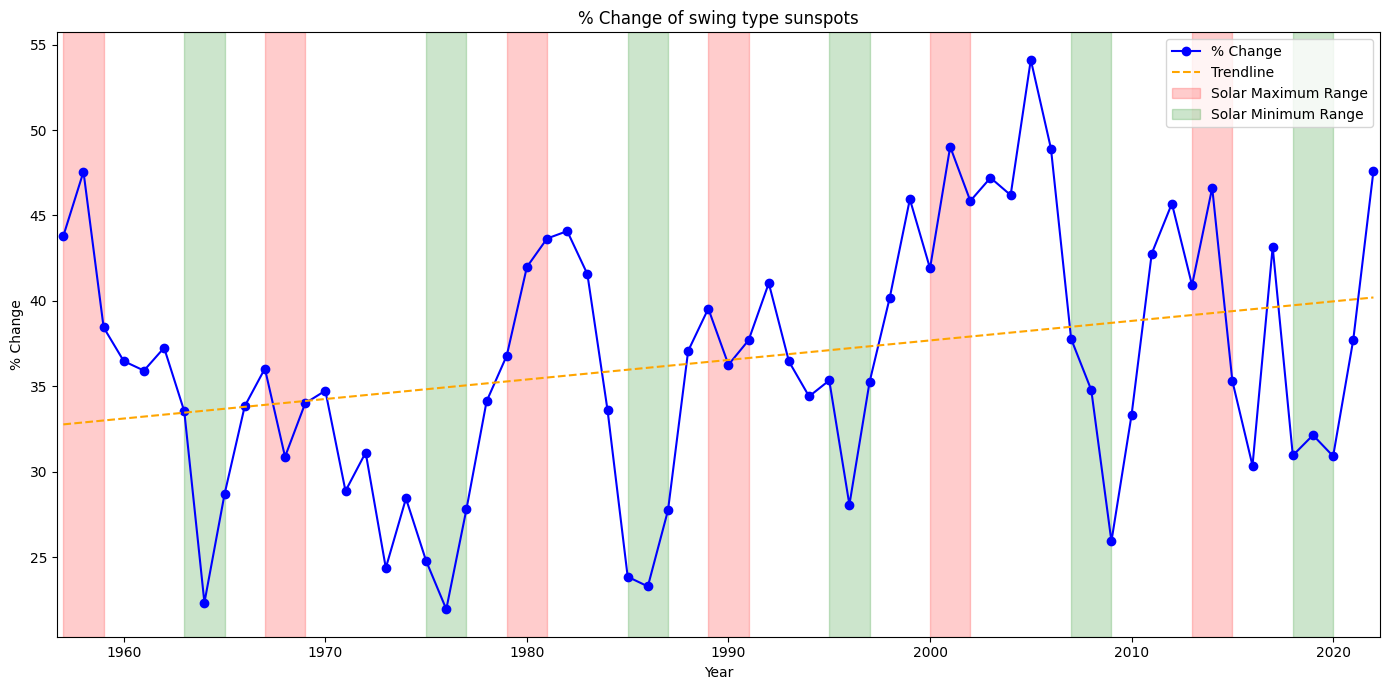

In [19]:
# Convert solar maximum and minimum years to ranges
solar_maximum_ranges = [(int(max_year) - 1, int(max_year) + 1) for max_year in solar_maximum_years]
solar_minimum_ranges = [(int(min_year) - 1, int(min_year) + 1) for min_year in solar_minimum_years]

years = [int(year) for year in list_of_years]
percentages = []
years_graph = []

for year, percent in list_of_percentages.items():
    if int(year) >= 1954 and int(year) < 2023:
        percentages.append(percent*100)
        years_graph.append(year)

# Fit a linear regression line
z = np.polyfit(years_graph, percentages, 1)
trendline = np.poly1d(z)

plt.figure(figsize=(14, 7))
plt.plot(years_graph, percentages, marker='o', linestyle='-', color='b', label='% Change')
plt.plot(years_graph, trendline(years_graph), color='orange', linestyle='--', label='Trendline')

# Highlight solar maximum ranges (in light red)
for start, end in solar_maximum_ranges:
    plt.axvspan(start, end, color='red', alpha=0.2, label='Solar Maximum Range' if start == int(solar_maximum_years[0]) - 1 else '')

# Highlight solar minimum ranges (in light green)
for start, end in solar_minimum_ranges:
    plt.axvspan(start, end, color='green', alpha=0.2, label='Solar Minimum Range' if start == int(solar_minimum_years[0]) - 1 else '')
plt.margins(x=.005)
plt.title('% Change of swing type sunspots')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.tight_layout()
plt.savefig("% Change of swing type sunspots")
plt.show()

In [36]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter out rows where 'group nr.' is NaN or contains letters
# Group number of NAN indicates data wasnt available on that day/time
# Group number with letters indicates the observers were unsure if the sunspot was part of a particular group
df = df[df['group nr.'].notna() & df['group nr.'].apply(lambda x: re.match(r'^\d+$', str(x)) is not None)]

# Unique list of years in the dataset
years = sorted(df['year'].unique())
MAX_GAP_DAYS = 5
# Initialize a dictionary to store the average lifespan by year
average_lifespan_by_year = []

for year in years:
    # Filter the DataFrame for the current year
    df_year = df[df['year'] == year]

    # Initialize a dictionary to track the days the sunspot groups appear for the current year
    group_dates = {}

    # Process each row -> looping through the current year and doing operations one row at a time
    for index, row in df_year.iterrows():
        group_number = row['group nr.']
        date_obj = row['date']

        # If group is seen for the first time, initialize a list in the dictionary
        if group_number not in group_dates:
            group_dates[group_number] = [date_obj]
        else:
            # Check if the new observation is 120 days or more after the last recorded date
            last_date = group_dates[group_number][-1]
            if (date_obj - last_date).days >= 120:
                # Reset the list: remove previous occurrences and start fresh
                group_dates[group_number] = [date_obj]
            else:
                # Otherwise, append the new date
                group_dates[group_number].append(date_obj)

    # Checks for potential overlaps by comparing the last two months of the current year
    # with the first two months of the next year. This can be extended to however many months you wish to filter
    if year + 1 in years:
        df_current_last_two_months = df[(df['year'] == year) & (df['month'] >= 11)]
        df_next_first_two_months = df[(df['year'] == year + 1) & (df['month'] <= 2)]
        
        for index, row in df_current_last_two_months.iterrows():

            group_number = row['group nr.'] # 802
            # Check if this group also appears in the next year's first two months
            df_next_group = df_next_first_two_months[df_next_first_two_months['group nr.'] == group_number]
            
            if not df_next_group.empty:
                latest_next_year_date = df_next_group['date'].max()
                current_last_date = group_dates[group_number][-1]
                if latest_next_year_date not in group_dates[group_number]:
                    group_dates[group_number].append(latest_next_year_date)
                    # print(group_dates[str(group_number)])

    average_lifespan_by_year.append(group_dates)

In [37]:
average_lifespan_undeveloped = {}
years = sorted(df['year'].unique())  # Ensure correct alignment with years
std_undeveloped_year = {}
group_lifespans_by_year = {}

for year_index, (year, year_dict) in enumerate(zip(years, average_lifespan_by_year)):
    total_lifespan = 0
    life_span_of_undeveloped_by_group = {}
    group_lifespans = []  # List to hold lifespans for undeveloped groups

    # Get the corresponding categorization for the current year from group_categories_global
    group_categories_for_year = group_categories_global[year_index]

    for group_num, dates in year_dict.items():
        # Ensure the group is classified as "undeveloped" for this year
        if group_categories_for_year.get(group_num) == "undeveloped":
            min_date = min(dates)
            max_date = max(dates)
            lifespan = (max_date - min_date).days + 1  # Include both endpoints
            group_lifespans.append(lifespan)
            total_lifespan += lifespan
            life_span_of_undeveloped_by_group[group_num] = lifespan
            if lifespan >= 80:
                print(f"Year: {year}, Group: {group_num}, min: {min_date}, max: {max_date}, lifespan: {lifespan}")

    # Calculate average lifespan for undeveloped groups in this year
    if life_span_of_undeveloped_by_group:
        # print(total_lifespan)
        average_lifespan_undeveloped[year] = total_lifespan / len(life_span_of_undeveloped_by_group)
        std_undeveloped_year[year] = np.std(group_lifespans)
        group_lifespans_by_year[year] = group_lifespans
    else:
        average_lifespan_undeveloped[year] = 0  # If no undeveloped groups exist, set average to 0 for that year
        std_undeveloped_year[year] = 0

Year: 1969, Group: 502, min: 1969-09-22 00:00:00, max: 1969-12-10 00:00:00, lifespan: 80
Year: 1972, Group: 2, min: 1972-01-05 00:00:00, max: 1972-04-01 00:00:00, lifespan: 88


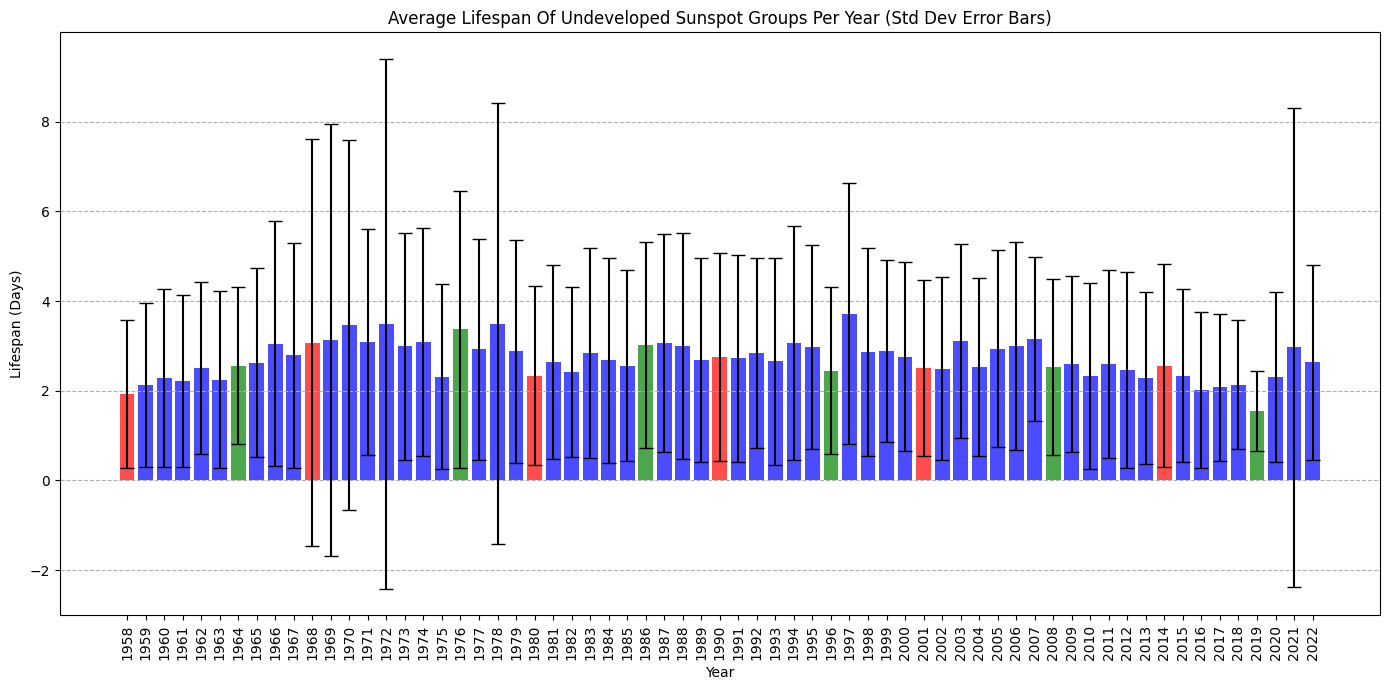

In [38]:
# Convert the years in average_lifespan_by_year to strings
average_lifespan_undeveloped = {str(year): value for year, value in average_lifespan_undeveloped.items()}
std_error_arr = []

# Define colors for solar maximum, minimum, and other years
colors = []
for year in list_of_years:
    if int(year) in solar_maximum_years:
        colors.append('red')  # Solar maximum years
    elif int(year) in solar_minimum_years:
        colors.append('green')  # Solar minimum years
    else:
        colors.append('blue')  # Other years

# Initialize the test list with values corresponding to list_of_new_years
test = []
for year in list_of_years:
    if year in average_lifespan_undeveloped:
        test.append(average_lifespan_undeveloped[year])
        std_error_arr.append(std_undeveloped_year[int(year)])
        # print(std_undeveloped_year[int(year)])
    else:
        test.append(0)
        std_error_arr.append(0)

plt.figure(figsize=(14, 7))
plt.bar(list_of_years, test, color=colors, alpha=0.7, yerr=std_error_arr, capsize=5)
plt.title('Average Lifespan Of Undeveloped Sunspot Groups Per Year (Std Dev Error Bars)')
plt.xlabel('Year')
plt.ylabel('Lifespan (Days)')
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('std')
plt.show()

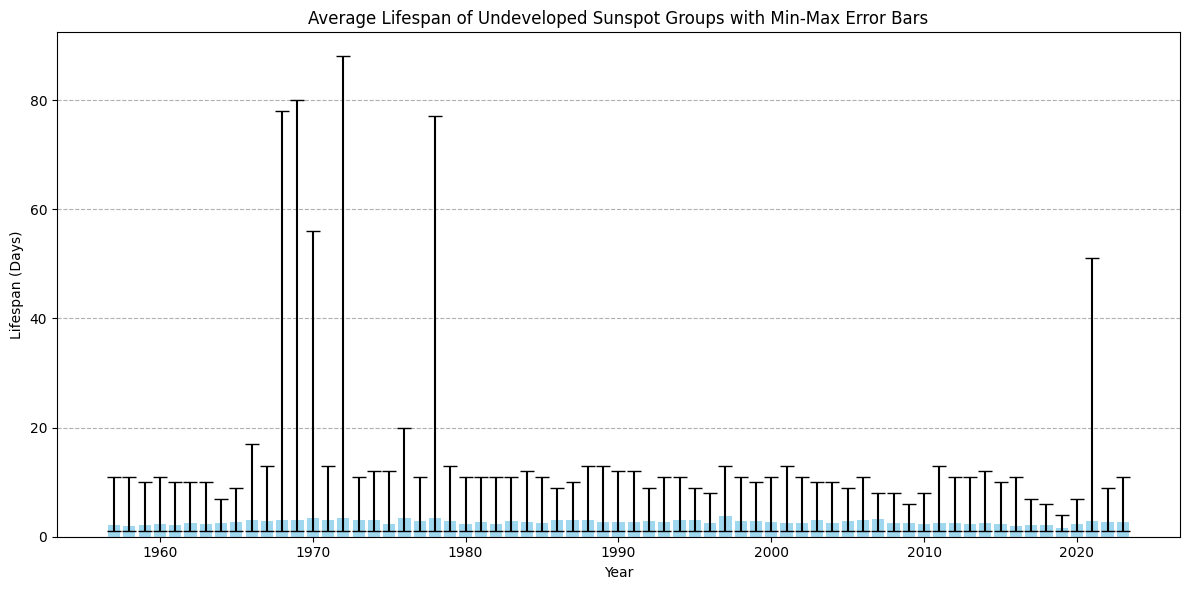

In [40]:
#min-max
# Prepare lists for plotting
years_list = sorted(group_lifespans_by_year.keys())
bar_heights = []
error_lower = []
error_upper = []

for year in years_list:
    lifespans = group_lifespans_by_year[year]
    avg = np.mean(lifespans)
    min_val = np.min(lifespans)
    max_val = np.max(lifespans)
    
    bar_heights.append(avg)
    error_lower.append(avg - min_val)   # How far the minimum is below the average
    error_upper.append(max_val - avg)     # How far the maximum is above the average

# Combine into an asymmetric error array
yerr = np.array([error_lower, error_upper])

plt.figure(figsize=(12, 6))
plt.bar(years_list, bar_heights, yerr=yerr, capsize=5, color='skyblue', alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Lifespan (Days)')
plt.title('Average Lifespan of Undeveloped Sunspot Groups with Min-Max Error Bars')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

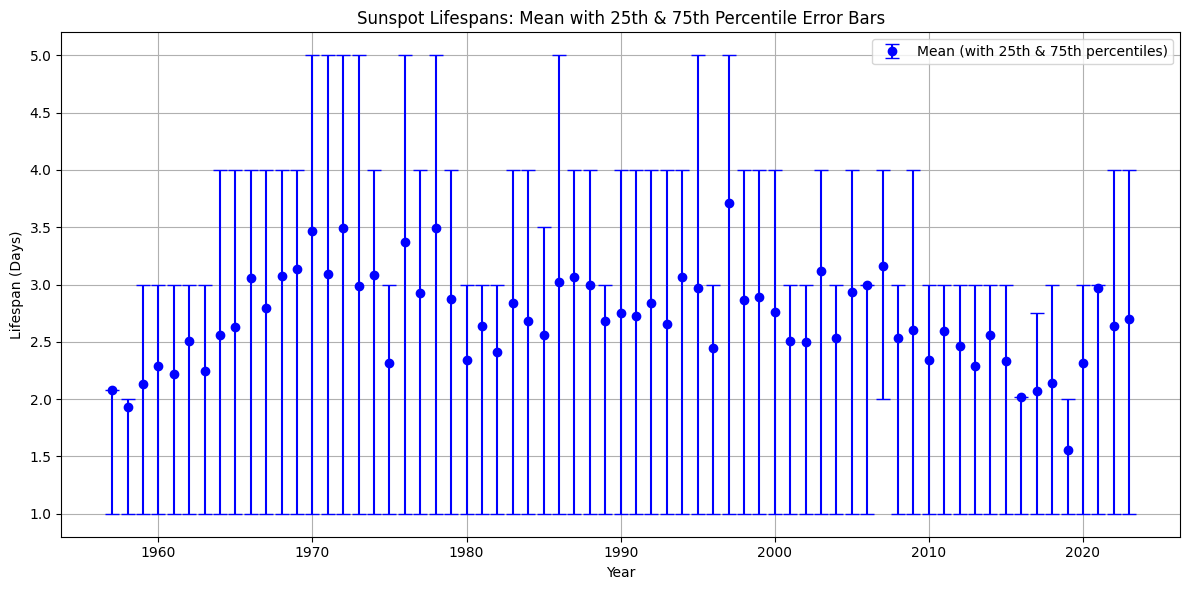

In [34]:
# Sort years (as strings, converting to int for proper ordering)
years_list = sorted(group_lifespans_by_year.keys(), key=lambda x: int(x))
mean_vals = []
q25_vals = []
q75_vals = []

for y in years_list:
    data = group_lifespans_by_year[y]
    mean_vals.append(np.mean(data))
    q25_vals.append(np.percentile(data, 25))
    q75_vals.append(np.percentile(data, 75))

# Compute asymmetric error bars:
lower_error = [max(0, m - q25) for m, q25 in zip(mean_vals, q25_vals)]
upper_error = [max(0, q75 - m) for m, q75 in zip(mean_vals, q75_vals)]
yerr = np.array([lower_error, upper_error])

plt.figure(figsize=(12, 6))
plt.errorbar(years_list, mean_vals, yerr=yerr, fmt='o', capsize=5, color='blue',
             label='Mean (with 25th & 75th percentiles)')
plt.xlabel('Year')
plt.ylabel('Lifespan (Days)')
plt.title('Sunspot Lifespans: Mean with 25th & 75th Percentile Error Bars')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


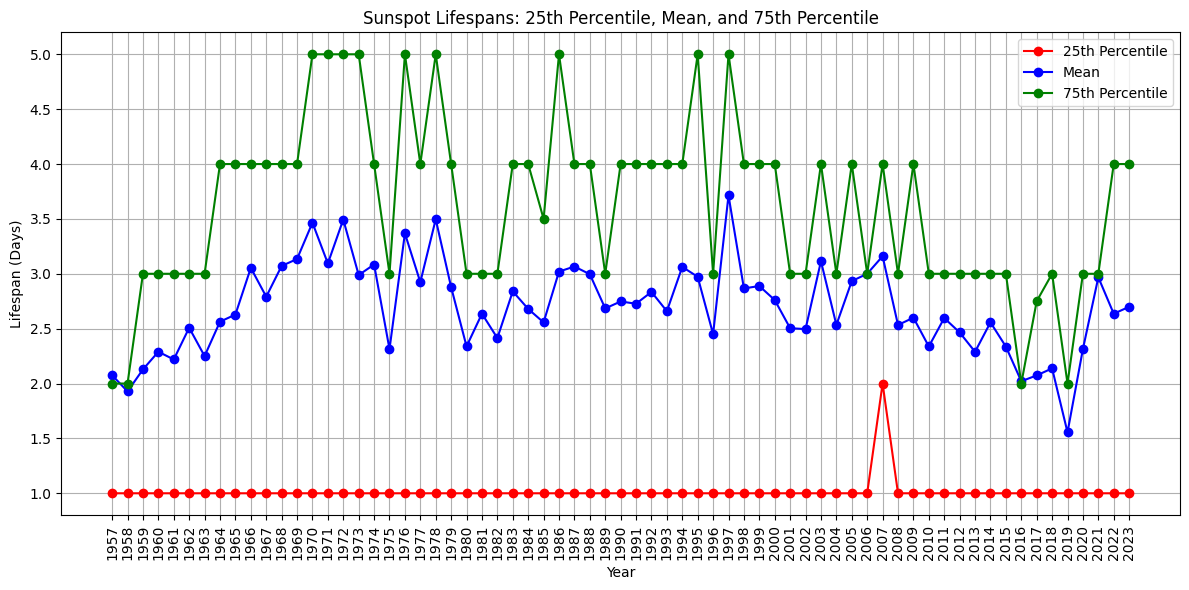

In [44]:
# Using the same example dictionary
years_list = sorted(group_lifespans_by_year.keys(), key=lambda x: int(x))
mean_vals = []
q25_vals = []
q75_vals = []

for y in years_list:
    data = group_lifespans_by_year[y]
    mean_vals.append(np.mean(data))
    q25_vals.append(np.percentile(data, 25))
    q75_vals.append(np.percentile(data, 75))

# Create x positions for plotting
x_positions = np.arange(len(years_list))

plt.figure(figsize=(12, 6))
plt.plot(x_positions, q25_vals, 'r-o', label='25th Percentile')
plt.plot(x_positions, mean_vals, 'b-o', label='Mean')
plt.plot(x_positions, q75_vals, 'g-o', label='75th Percentile')

plt.xticks(x_positions, years_list, rotation=90)
plt.xlabel('Year')
plt.ylabel('Lifespan (Days)')
plt.title('Sunspot Lifespans: 25th Percentile, Mean, and 75th Percentile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


DEVELOPED TYPES

In [120]:
average_lifespan_developed = {}
years = sorted(df['year'].unique())  # Ensure correct alignment with years

for year_index, (year, year_dict) in enumerate(zip(years, average_lifespan_by_year)):
    total_lifespan = 0
    life_span_of_developed_by_group = {}

    # Get the corresponding categorization for the current year from group_categories_global
    group_categories_for_year = group_categories_global[year_index]

    for group_num, dates in year_dict.items():
        # Ensure the group is classified as "undeveloped" for this year
        if group_categories_for_year.get(group_num) == "developed":
            min_date = min(dates)
            max_date = max(dates)
            lifespan = (max_date - min_date).days + 1  # Include both endpoints
            total_lifespan += lifespan
            life_span_of_developed_by_group[group_num] = lifespan

    # Calculate average lifespan for undeveloped groups in this year
    if life_span_of_developed_by_group:
        average_lifespan_developed[year] = total_lifespan / len(life_span_of_developed_by_group)
    else:
        average_lifespan_developed[year] = 0  # If no undeveloped groups exist, set average to 0

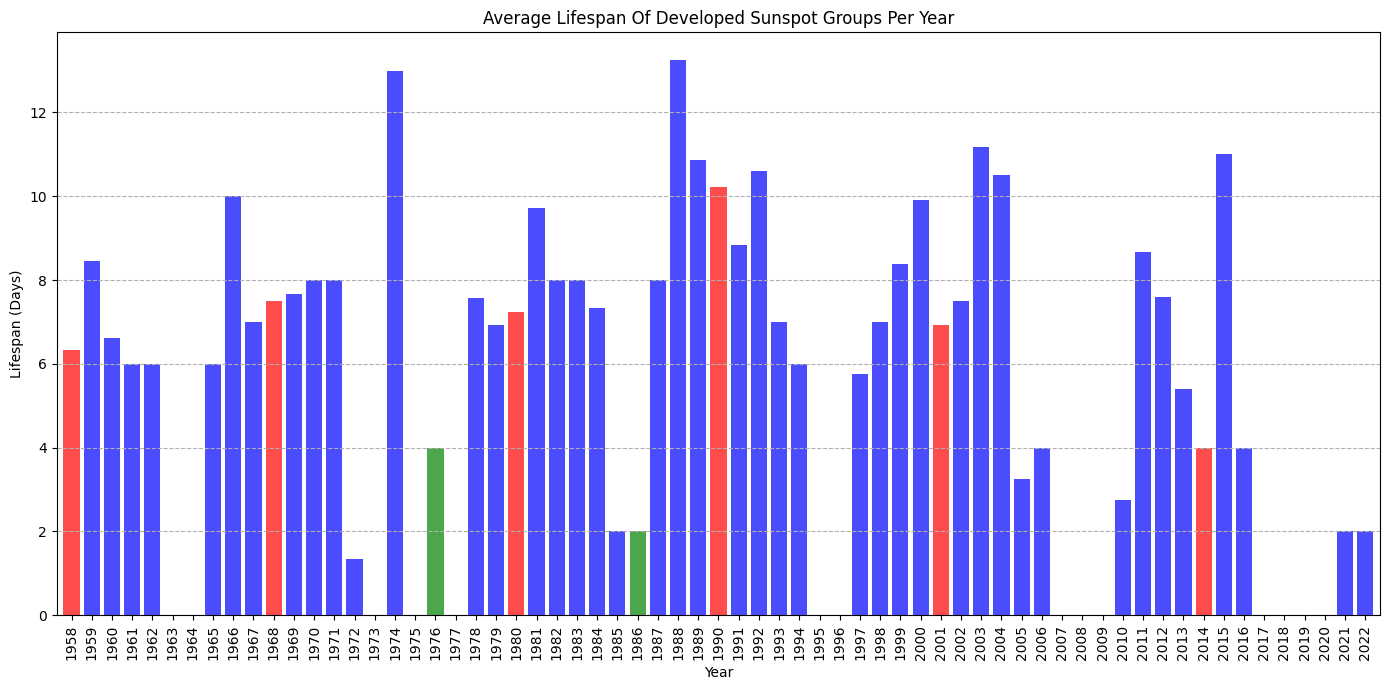

In [122]:
# Convert the years in average_lifespan_by_year to strings
average_lifespan_developed = {str(year): value for year, value in average_lifespan_developed.items()}

test = []
for year in list_of_years:
    if year in average_lifespan_developed:
        test.append(average_lifespan_developed[year])
    else:
        test.append(0)

colors = []
for year in list_of_years:
    if int(year) in solar_maximum_years:
        colors.append('red')  # Solar maximum years
    elif int(year) in solar_minimum_years:
        colors.append('green')  # Solar minimum years
    else:
        colors.append('blue')  # Other years


# Plotting the data
plt.figure(figsize=(14, 7))
plt.bar(list_of_years, test, color=colors, alpha = 0.7)
plt.title('Average Lifespan Of Developed Sunspot Groups Per Year')
plt.xlabel('Year')
plt.ylabel('Lifespan (Days)')
plt.grid(axis='y', linestyle='--')
plt.margins(x=0.005)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Average Lifespan Of Developed Sunspot Groups Per Year')
plt.show()

In [16]:
average_lifespan_swing = {}
years = sorted(df['year'].unique())  # Ensure correct alignment with years

for year_index, (year, year_dict) in enumerate(zip(years, average_lifespan_by_year)):
    total_lifespan = 0
    life_span_of_swing_by_group = {}

    # Get the corresponding categorization for the current year from group_categories_global
    group_categories_for_year = group_categories_global[year_index]

    for group_num, dates in year_dict.items():
        # Ensure the group is classified as "undeveloped" for this year
        if group_categories_for_year.get(group_num) == "swing":
            min_date = min(dates)
            max_date = max(dates)
            lifespan = (max_date - min_date).days + 1  # Include both endpoints
            total_lifespan += lifespan
            life_span_of_swing_by_group[group_num] = lifespan

    # Calculate average lifespan for undeveloped groups in this year
    if life_span_of_swing_by_group:
        average_lifespan_swing[year] = total_lifespan / len(life_span_of_swing_by_group)
    else:
        average_lifespan_swing[year] = 0  # If no undeveloped groups exist, set average to 0

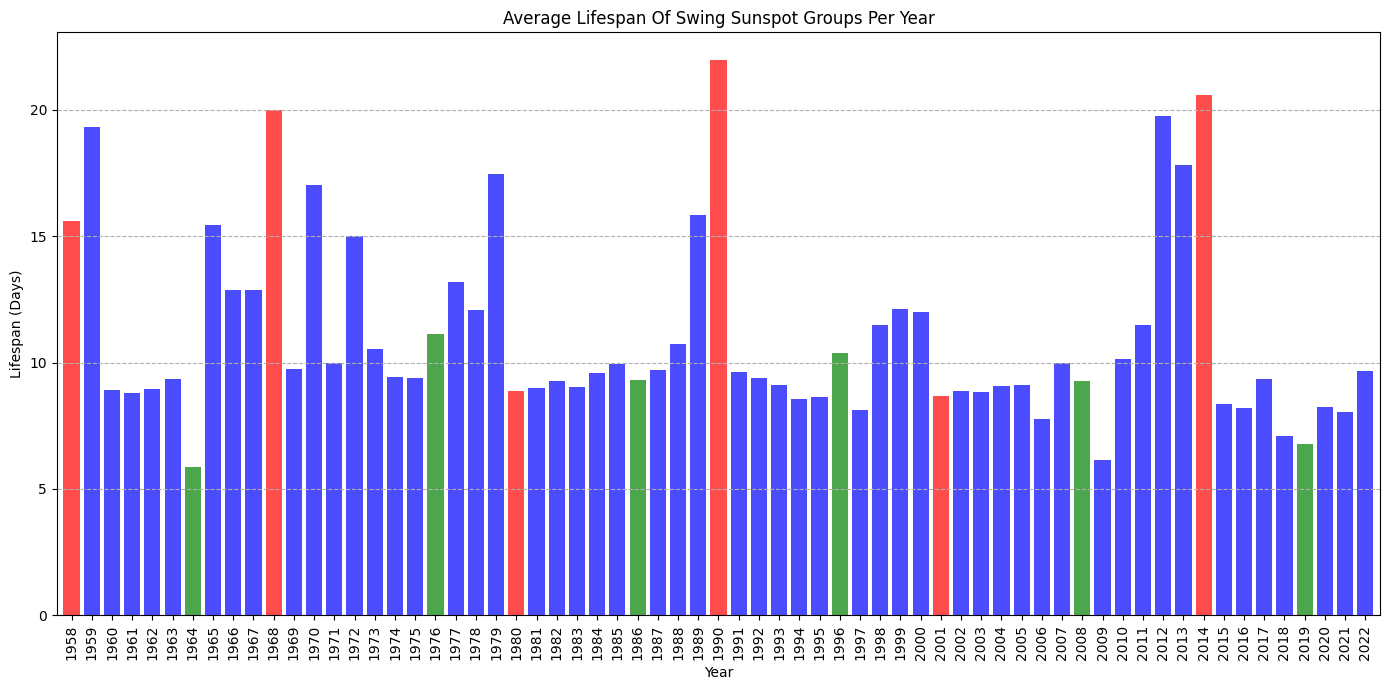

In [17]:
average_lifespan_swing = {str(year): value for year, value in average_lifespan_swing.items()}

# Initialize the test list with values corresponding to list_of_new_years
test = []
for year in list_of_years:
    if year in average_lifespan_swing:
        test.append(average_lifespan_swing[year])
    else:
        test.append(0)

colors = []
for year in list_of_years:
    if int(year) in solar_maximum_years:
        colors.append('red')  # Solar maximum years
    elif int(year) in solar_minimum_years:
        colors.append('green')  # Solar minimum years
    else:
        colors.append('blue')  # Other years

# Plotting the data
plt.figure(figsize=(14, 7))
plt.bar(list_of_years, test, color=colors, alpha = 0.7)
plt.title('Average Lifespan Of Swing Sunspot Groups Per Year')
plt.xlabel('Year')
plt.ylabel('Lifespan (Days)')
plt.grid(axis='y', linestyle='--')
plt.margins(x=0.005)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Average Lifespan Of Swing Sunspot Groups Per Year')
plt.show()

In [18]:
average_lifespan_decay = {}
years = sorted(df['year'].unique())  # Ensure correct alignment with years

for year_index, (year, year_dict) in enumerate(zip(years, average_lifespan_by_year)):
    total_lifespan = 0
    life_span_of_decay_by_group = {}

    # Get the corresponding categorization for the current year from group_categories_global
    group_categories_for_year = group_categories_global[year_index]

    for group_num, dates in year_dict.items():
        # Ensure the group is classified as "undeveloped" for this year
        if group_categories_for_year.get(group_num) == "decayed":
            min_date = min(dates)
            max_date = max(dates)
            lifespan = (max_date - min_date).days + 1  # Include both endpoints
            total_lifespan += lifespan
            life_span_of_decay_by_group[group_num] = lifespan
            

    # Calculate average lifespan for undeveloped groups in this year
    if life_span_of_decay_by_group:
        average_lifespan_decay[year] = total_lifespan / len(life_span_of_decay_by_group)
    else:
        average_lifespan_decay[year] = 0  # If no undeveloped groups exist, set average to 0    

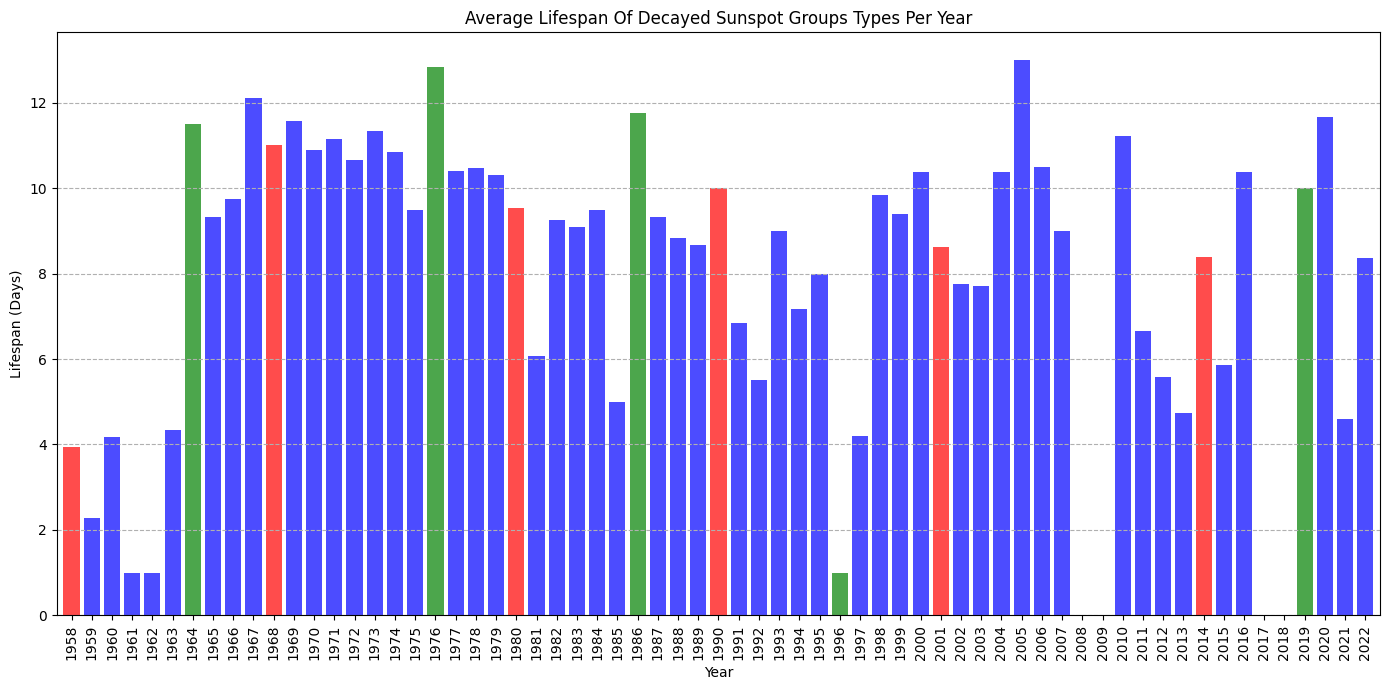

In [19]:
average_lifespan_decay = {str(year): value for year, value in average_lifespan_decay.items()}

# Initialize the test list with values corresponding to list_of_new_years
test = []
for year in list_of_years:
    if year in average_lifespan_decay:
        test.append(average_lifespan_decay[year])
    else:
        test.append(0)

colors = []
for year in list_of_years:
    if int(year) in solar_maximum_years:
        colors.append('red')  # Solar maximum years
    elif int(year) in solar_minimum_years:
        colors.append('green')  # Solar minimum years
    else:
        colors.append('blue')  # Other years

# Plotting the data
plt.figure(figsize=(14, 7))
plt.bar(list_of_years, test, color=colors, alpha = 0.7)
plt.title('Average Lifespan Of Decayed Sunspot Groups Types Per Year')
plt.xlabel('Year')
plt.ylabel('Lifespan (Days)')
plt.grid(axis='y', linestyle='--')
plt.margins(x=0.005)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Average Lifespan Of Decayed Sunspot Groups Types Per Year')
plt.show()